In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# np.random.seed(123)
sns.set_style("whitegrid")

In [2]:
# Bigger font
# sns.set_context("poster")
# Figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4
plt.rc('figure.subplot', wspace=.33)

A. Data Overview

1. Read TRAIN and TEST data. Assign the target column to a variable for later use.
2. Check their shapes. There can be more or less features in the TEST.
3. Examine TRAIN and TEST, and the types of the features.  
**Checking how the data was generated. Check if the rows or columns were ordered or shuffled.** This is actually examined in every step.
4. Check if there are NaNs
    - How many nans for each row
    - For each column

B.Data Cleaning

1. Fill nans.
2. Remove features by first looking at unique values on each feature. Then, encode features so as to find duplicated columns.
3. Visualization to find more features to remove.
4. Separate columns into categorical and numerical variables.
5. Examine numerical features
6. Guess how the dataset was built.
7. Examine categorical features

Data analysis on the Titanic competition might be one of the first thing to do for now.

## 1. Describe

In [3]:
titanic_train = pd.read_csv("data/titanic.csv.gz")
print(titanic_train.shape)
print(titanic_train.dtypes)
titanic_train.head(5)

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It has 891 records and 12 columns, and one of them is the target.  
Some float and integer features can be seen.

Now, I look at a statistical summary of the variables with df.describe():
- **It doesn't consider non-numeric columns**
- Missing values can be seen in column 'Age' because 714 < 891

In [4]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


This would return the summary of the categorical variables **(the object ones)**.

In [5]:
# numerical = titanic_train.dtypes[(titanic_train.dtypes != "object") & (titanic_train.dtypes != "category")].index
# categorical = titanic_train.dtypes[(titanic_train.dtypes == "object") | (titanic_train.dtypes == "category")].index

def get_numcat_cols(titanic_train):
    numerical = titanic_train._get_numeric_data().columns
    categorical = titanic_train.columns.difference(numerical)
    return (numerical, categorical)

In [6]:
numerical, categorical = get_numcat_cols(titanic_train)

print(numerical)
print(categorical)

titanic_train[categorical].describe()

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Index(['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket'], dtype='object')


,Cabin,Embarked,Name,Sex,Ticket
count,204,889,891,891,891
unique,147,3,891,2,681
top,B96 B98,S,"Futrelle, Mr. Jacques Heath",male,1601
freq,4,644,1,577,7


- count = count of non-NaN records
- unique = number of unique categories
- top = the most frequently occurring value
- freq = the number of occurrences of the most frequent value

Whoever collects or provides data for download should also provide a list of variable descriptions. **Kaggle provides a list of descriptions.**

In [7]:
# VARIABLE DESCRIPTIONS:
# survival        Survival
#                 (0 = No; 1 = Yes)
# pclass          Passenger Class
#                 (1 = 1st; 2 = 2nd; 3 = 3rd)
# name            Name
# sex             Sex
# age             Age
# sibsp           Number of Siblings/Spouses Aboard
# parch           Number of Parents/Children Aboard
# ticket          Ticket Number
# fare            Passenger Fare
# cabin           Cabin
# embarked        Port of Embarkation
#                 (C = Cherbourg; Q = Queenstown; S = Southampton)

## 2. Do I Need All of the Variables?

### a. PassengerId is just an id, so drop it

In [8]:
del titanic_train["PassengerId"]     # Remove PassengerId

### b. Survived. It's the target, so don't drop it
### c. Pclass, Sex, Age, SibSp, Parch, Fare and Embarked. Features that describe categories, so they  should be kept
### d. Name

In [9]:
print(sorted(titanic_train["Name"])[0:5])
titanic_train["Name"].describe()

['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward', 'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', 'Abelson, Mrs. Samuel (Hannah Wizosky)']


count                             891
unique                            891
top       Futrelle, Mr. Jacques Heath
freq                                1
Name: Name, dtype: object

A categorical variable that is unique to each case isn't useful.  
There may be a way to  make this feature useful by grouping some values, so for now I'just keep it.

### e. Ticket

In [10]:
print(titanic_train["Ticket"][0:5])
titanic_train["Ticket"].describe()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object


count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

This one has too many unique values, so drop it

In [11]:
del titanic_train["Ticket"]        # Remove Ticket

### f. Cabin

In [12]:
print(titanic_train["Cabin"][0:5])
titanic_train["Cabin"].describe()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object


count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

This one has also too many unique values, but it may be able to be grouped.

## 3. Should I Transform Any Variable?

Encoding and grouping categorical variables

### a. Survived
This one will need to be submitted as 0's and 1's so keep it.

### b. Pclass

In [13]:
new_Pclass = pd.Categorical(titanic_train["Pclass"],
                           ordered=True)
new_Pclass = new_Pclass.rename_categories(["Class1","Class2","Class3"])
titanic_train["Pclass"] = new_Pclass
new_Pclass.describe()

,counts,freqs
categories,,
Class1,216,0.242424
Class2,184,0.206510
Class3,491,0.551066


### b. Cabin. Each Cabin is in a general section of the ship indicated by the capital letter at the start of each factor level. The thing is to reduce the number of categories by grouping.

In [14]:
titanic_train["Cabin"].unique()   # Check unique cabins

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [15]:
char_cabin = titanic_train["Cabin"].astype(str)  # Convert data to str
new_Cabin = np.array([cabin[0] for cabin in char_cabin])  # Take first letter
new_Cabin = pd.Categorical(new_Cabin)
titanic_train["Cabin"] = new_Cabin
new_Cabin.describe()

,counts,freqs
categories,,
A,15,0.016835
B,47,0.052750
C,59,0.066218
D,33,0.037037
E,32,0.035915
F,13,0.014590
G,4,0.004489
T,1,0.001122
n,687,0.771044


## 4. Are there NA Values or Strange Values?

For numerical data:
- If there are a few missing values, remove the records.
- If there are many, do one of the following
    - Replace the null values with **0s**. A person's age can't be 0.
    - Replace the null values with some **central value** like the mean or median. 
    - **Impute values** (estimate values using statistical/predictive modeling methods). Imputation methods include filling in values based on "similar" or "neighboring" records **(K-nearest-neighbors imputation)** and filling in values based on regression models. Using predictive models to fill in missing values adds an extra layer of complexity to an analysis and can significantly increase processing time.

For categorical data, missing values can be treated as an additional category NA.

This shows how many missing values are on each column.

In [16]:
null_columns = titanic_train.columns[titanic_train.isnull().any()]
titanic_train[null_columns].isnull().sum()

Age         177
Embarked      2
dtype: int64

### a. Age

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c1fcfd0>]],
      dtype=object)

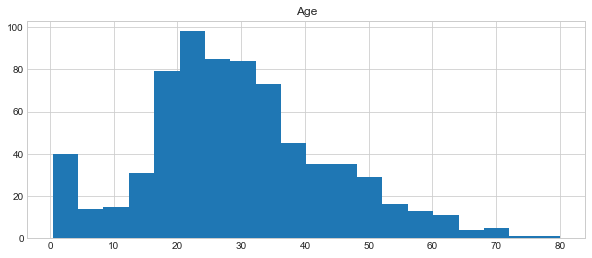

In [17]:
titanic_train.hist(column='Age',    # Column to plot
                   bins=20)         # Number of histogram bins

A good central tendency statistic would be the median.

In [18]:
new_age_var = np.where(titanic_train["Age"].isnull(), # Logical check
                       titanic_train["Age"].median(), # Value if check is true
                       titanic_train["Age"])     # Value if check is false
titanic_train["Age"] = new_age_var

Another way is by doing this

In [19]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN',  # Create imputation model
              strategy='median',     # Use mean imputation
              axis=0)                # Impute by column

titanic_train["Age"] = imp.fit_transform(titanic_train[["Age"]])

## Are there outliers?

In [20]:
numerical, categorical = get_numcat_cols(titanic_train)

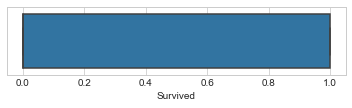

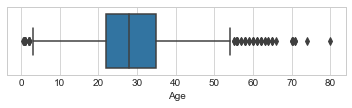

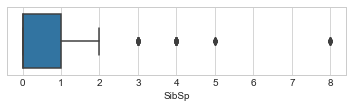

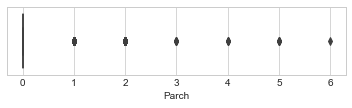

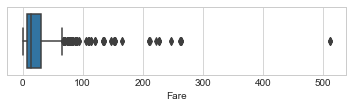

In [21]:
for feature in numerical:
    fig = plt.figure(figsize=(5, 1.6))
    sns.boxplot(x=feature, data=titanic_train, orient="h")
    plt.tight_layout()
    plt.show()

### a. Fare

The box represents 50% of the data.

There are some values that are too far away from the typical value, but the only one that's considered an outlier should be the one(s) who paid > 500. I'll just keep them.

In [22]:
index = np.where(titanic_train["Fare"] == max(titanic_train["Fare"]) )
titanic_train.loc[index]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
258,1,Class1,"Ward, Miss. Anna",female,35.0,0,0,512.3292,n,C
679,1,Class1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,512.3292,B,C
737,1,Class1,"Lesurer, Mr. Gustave J",male,35.0,0,0,512.3292,B,C


## Should I Create New Variables?

This can be called feature extraction from text or image.

And also creating a new variable can be as simple as taking one variable and adding, multiplying or dividing by another. I'll just keep it that way.

## Final description

In [23]:
titanic_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,Class3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,n,S
1,1,Class1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,1,Class3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,n,S
3,1,Class1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S
4,0,Class3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,n,S


In [24]:
titanic_train.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.361582,0.523008,0.381594,32.204208
std,0.486592,13.019697,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [25]:
numerical, categorical = get_numcat_cols(titanic_train)
titanic_train[categorical].describe()

,Cabin,Embarked,Name,Pclass,Sex
count,891,889,891,891,891
unique,9,3,891,3,2
top,n,S,"Futrelle, Mr. Jacques Heath",Class3,male
freq,687,644,1,491,577
